In [6]:
import numpy as np
import pandas as pd
import import_ipynb
import pair_selection_DBSCAN_funclist_for_training as myFunc
import matplotlib.pyplot as plt

import math
import sklearn
from datetime import datetime

from sklearn import datasets, linear_model
from tqdm import tqdm
from sklearn.preprocessing import PolynomialFeatures
import pickle

import warnings
warnings.filterwarnings('ignore')

importing Jupyter notebook from pair_selection_DBSCAN_funclist_for_training.ipynb


In [452]:
def trade_index (trial=-1):
    '''return start_date, end_date'''
    
    monthly = pd.date_range('2009-12-31', '2022-1-1', freq='MS')
    period_candi = [(6,1),(12,7),(24,12)]
    formation_train = {}
    for cnd in period_candi:

        train_window_width = cnd[0]
        test_window_width = cnd[1]

        train_period = []
        test_period = []
        for i in range(len(monthly)- train_window_width-test_window_width):
            train_start_date = monthly[i]
            train_end_date = monthly[i+train_window_width]
            test_end_date = monthly[i+train_window_width+test_window_width]

            if test_end_date.year < 2017:

                train_period.append((train_start_date.strftime("%Y-%m-%d"), train_end_date.strftime("%Y-%m-%d"), test_end_date.strftime("%Y-%m-%d")))
            
            elif test_end_date.year >=2017:

                test_period.append((train_start_date.strftime("%Y-%m-%d"), train_end_date.strftime("%Y-%m-%d"), test_end_date.strftime("%Y-%m-%d")))
                
        formation_train[cnd] = (train_period, test_period)
    # trading 기간 2019-01-01 ~ 2021-12-31
    performance_test = formation_train[(12,7)][1][30:]

    if trial == -1:

        return performance_test[0][1], performance_test[-1][-1]
        
    else:
        return performance_test[trial-1][1], performance_test[trial-1][2]


def plotting_inv_trial (reg_pkl, price_df, trial=1, method='cum', total=False):

    if pd.isnull(reg_pkl[f'trial_{trial}'][0]) == True:
        return print('None')

    else:
        trial_df = pd.DataFrame(reg_pkl[f'trial_{trial}'])

    result_index =  price_df.loc[trade_index(trial)[0]:trade_index(trial)[1]].index.unique()[:trial_df.iloc[0,0].size]
    
    if method == 'cum':

        port = np.zeros((len(result_index), len(trial_df.columns)))

        for idx, pair in enumerate(trial_df.columns):
            port[:, idx] = trial_df[pair][0]

        plt.figure(figsize=(14,6))
        plt.title(f'Cummulative Return of Portfolio Trial {trial}')
        plt.plot(result_index, np.average(port, axis=1), c='b',label=f'Portfolio {str(result_index[0])[2:11]}- {str(result_index[-1])[2:11]}')
        plt.legend()
        plt.show()


    # if method == 'mdd':

    # if method == 'sharp':
def annualized_sharpe (reg_pkl, price_df, trial=1):
    '''Trial의 샤프를 구해준다'''

    trial_df = pd.DataFrame(reg_pkl[f'trial_{trial}'])

    result_index =  price_df.loc[trade_index(trial)[0]:trade_index(trial)[1]].index.unique()[:trial_df.iloc[0,0].size]

    port = np.zeros((len(result_index), len(trial_df.columns)))

    for idx, pair in enumerate(trial_df.columns):
        port[:, idx] = trial_df[pair][0]

    port_path = port.sum(axis=1) / len(trial_df.columns)

    annualized_sharpe= pd.DataFrame(port_path).pct_change().dropna().mean().item() * 252 / (pd.DataFrame(port_path).pct_change().dropna().std().item() * np.sqrt(252))

    return annualized_sharpe, port_path

def annualized_sharpe_total (reg_pkl, price_df, with_nan='No'):
    
    tmp = np.zeros((122, 35))
    count = 0
    for idx in range(1,len(reg_pkl)+1):
        
        sharpe, port_path = annualized_sharpe(reg_pkl, price_df, idx)

        if pd.isnull(sharpe) is True:
            pass
        else:
            tmp[:,count] = port_path[:122]
            count += 1
        #tmp = pd.concat([tmp, list(port_path)], ignore_index=True)

    all_path = tmp[:,:count]

    cov_df = pd.DataFrame(all_path).pct_change().dropna().cov()
    all_mean = pd.DataFrame(all_path).pct_change().dropna().mean().mean() * 252

    nan_count = 0
    count = 0
    for x in range(1, 32):
        check = annualized_sharpe(reg_pkl, price_df, x)[0]
        if pd.isnull(check) is True:
            nan_count += 1
        else:
            count += 1

    if with_nan =='No':
        all_std = np.sqrt(cov_df.sum().sum()/count**2) * np.sqrt(252)
        sharpe = all_mean / all_std
    else:
        all_std = np.sqrt(cov_df.sum().sum() / (count+nan_count)**2) * np.sqrt(252)
        sharpe = all_mean/all_std

    return sharpe

def individual_pairs_return (result, price_df, trial=1):    
    
    trial_df = pd.DataFrame(result[f'trial_{trial}'])
    result_index =  price_df.loc[trade_index(2)[0]:trade_index(2)[1]].index.unique()[:trial_df.iloc[0,0].size]

    trial_columns = list(pd.DataFrame(result[f'trial_{trial}']).columns)

    for idx, x in enumerate(trial_columns):
        pair = trial_columns[idx]

        pair_path = trial_df[pair][0][0]
        pair_rtn = (pair_path[-1] - pair_path[0])/pair_path[0]
        annu_pair_rtn = 2 * pair_rtn

        plt.figure(figsize=(14,6))
        plt.plot(result_index, pair_path, label=f"{pair}'s Path")
        plt.legend()
        plt.show()

        print(f"{pair}'s annualized return = {annu_pair_rtn}")

def individual_trial_return (reg_pkl, price_df, trial=1):

    if pd.isnull(reg_pkl[f'trial_{trial}'][0]) == True:
        return print('None')

    else:
        trial_df = pd.DataFrame(reg_pkl[f'trial_{trial}'])

    result_index =  price_df.loc[trade_index(trial)[0]:trade_index(trial)[1]].index.unique()[:trial_df.iloc[0,0].size]

    port = np.zeros((len(result_index), len(trial_df.columns)))

    for idx, pair in enumerate(trial_df.columns):
        port[:, idx] = trial_df[pair][0]
    
    mean_path = port.sum(axis=1) / port.shape[1]
    ann_path_return = 2 * (mean_path[-1] - mean_path[0])/mean_path[0]
    
    print(f"Trial {trial}'s annualized return = {ann_path_return}")

    return ann_path_return

In [138]:
price_df = pd.read_csv('./Data/us_etf_price.csv', parse_dates=['Date'], index_col=0)
with open('result_may_final_all.pkl','rb') as f:
    result = pickle.load(f)

# 개별 Trial 별 Port path 그리기

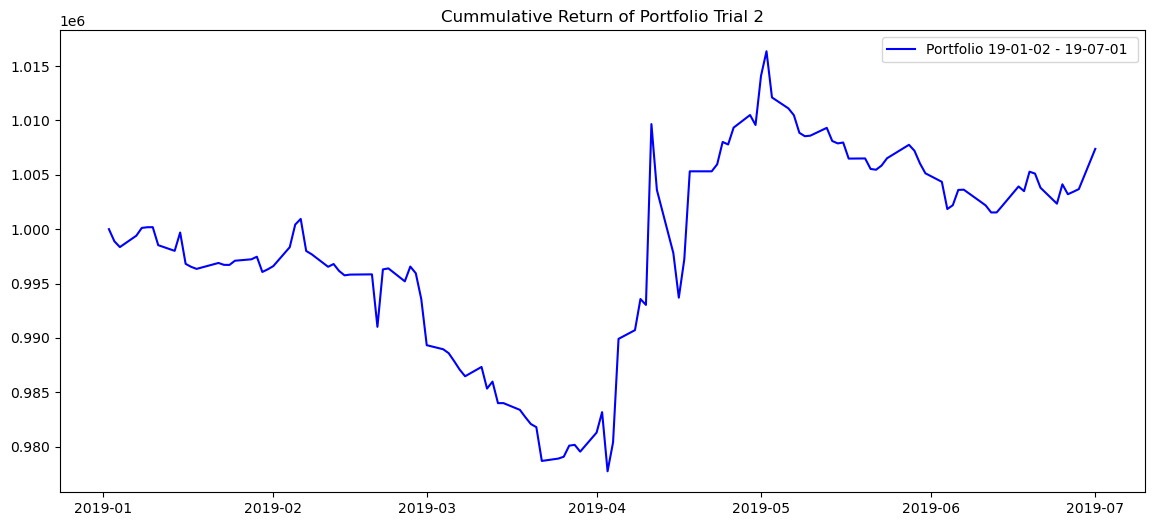

In [459]:
plotting_inv_trial(result, price_df, trial=2, method='cum')

# 총 포트폴리오의 연율화 샤프

In [453]:
a = annualized_sharpe_total(result, price_df, 'No')
a

2.0057024481729453

# ROI

### 각 Trial 별로 전체 리턴

In [457]:
for x in range(1, 32):
    individual_trial_return(result, price_df, x)
    '''이건 그래프 개많이 나옴'''
    #plotting_inv_trial(result, price_df, x)

None
Trial 2's annualized return = 0.014766704102949705
None
Trial 4's annualized return = -0.012721328475951683
Trial 5's annualized return = 0.0036589222106933592
Trial 6's annualized return = -0.19060990098571778
Trial 7's annualized return = 0.0
Trial 8's annualized return = -0.054433035680135015
None
None
None
None
Trial 13's annualized return = 0.012752056414286374
Trial 14's annualized return = 0.23016743304138165
Trial 15's annualized return = -0.051408523921966785
Trial 16's annualized return = 0.09261767304229736
Trial 17's annualized return = 0.06805112119674729
Trial 18's annualized return = -0.048438208183288575
Trial 19's annualized return = 0.024595743998209713
Trial 20's annualized return = -0.004808823020935059
None
None
None
None
Trial 25's annualized return = -0.0031925851364135744
None
Trial 27's annualized return = 0.17503279799397756
Trial 28's annualized return = 0.13873617700195312
Trial 29's annualized return = -0.013405552310943604
Trial 30's annualized return

## Trial 안에서 페어별로 

In [ ]:
individual_pairs_return(result, price_df, trial=2)

## MDD

In [15]:
trial_df = pd.DataFrame(result['trial_2'])

trial_columns = trial_df.columns

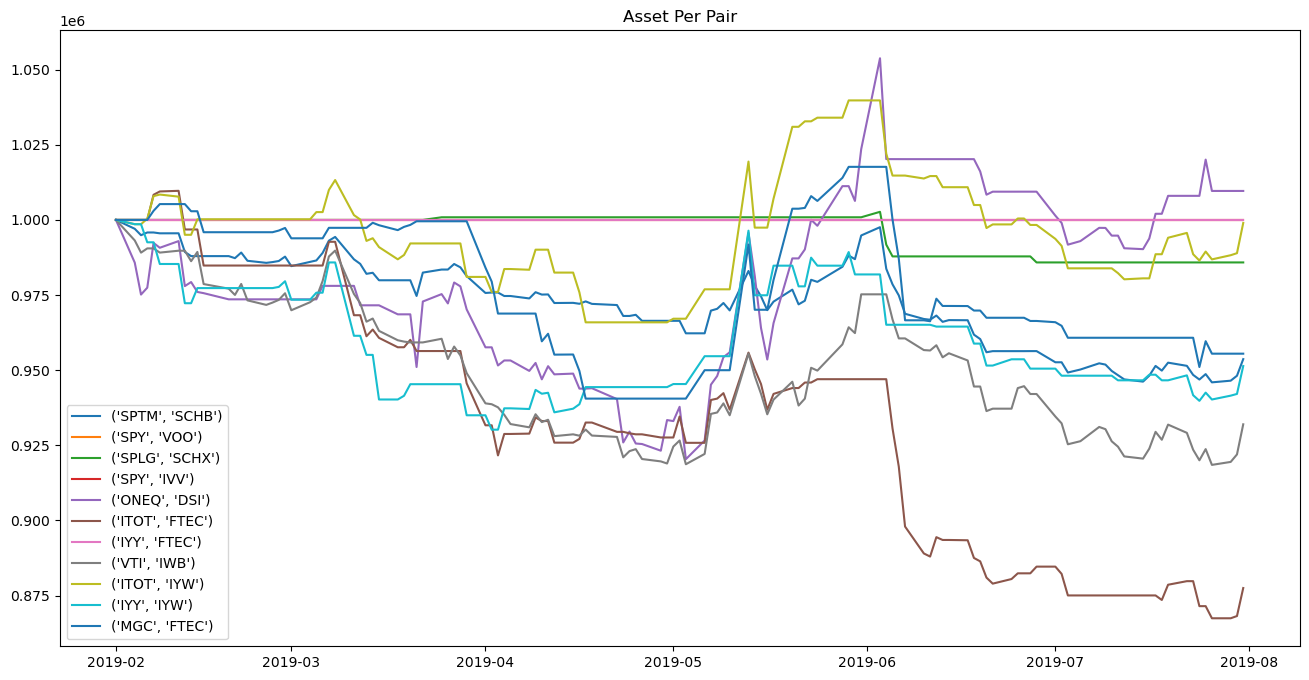

In [151]:
plt.figure(figsize=(16,8))
plt.title('Asset Per Pair')

for x in list(trial_df.columns):
    plt.plot(result_index, trial_df[x][0].reshape(-1,1), label=f'{x}')
    
plt.legend()
plt.show()

## Cumulative Return 개별 자산

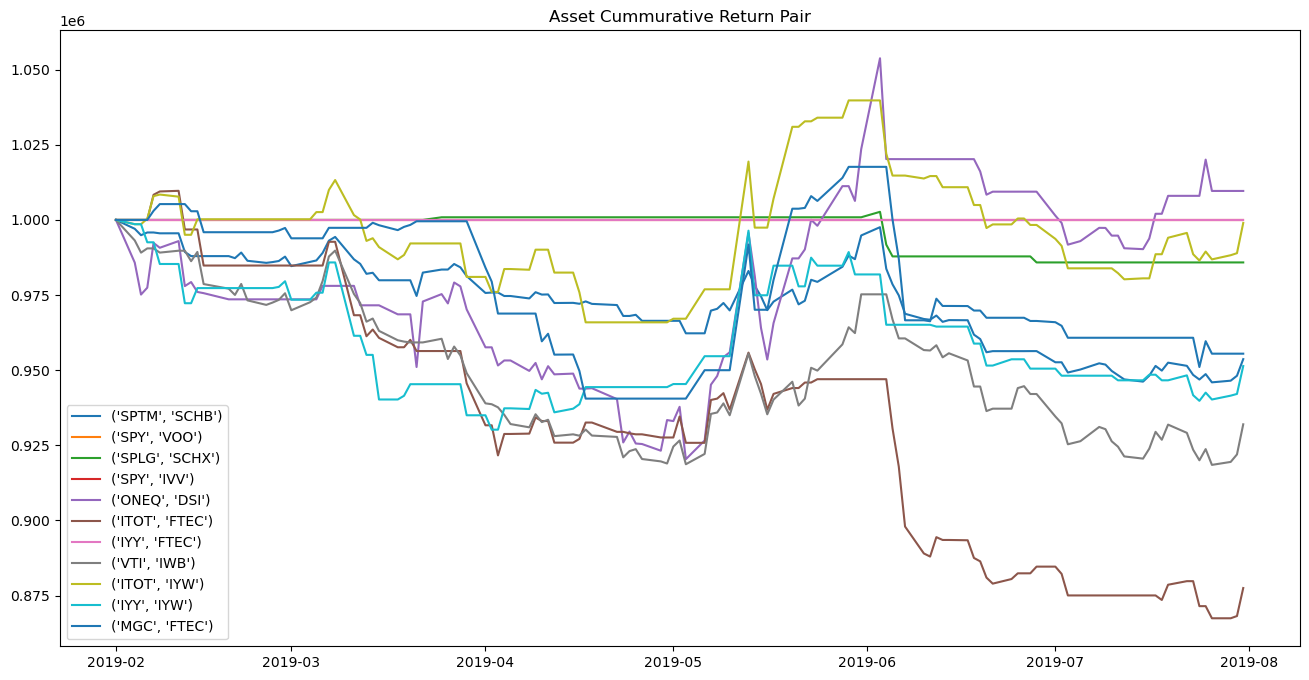

In [213]:
plt.figure(figsize=(16,8))
plt.title('Asset Cummurative Return Pair')

for x in list(trial_df.columns):
    plt.plot(result_index, trial_df[x][1].reshape(-1,1), label=f'{x}')
    
plt.legend()
plt.show()

## 동일가중 포트폴리오의 전체 수익률

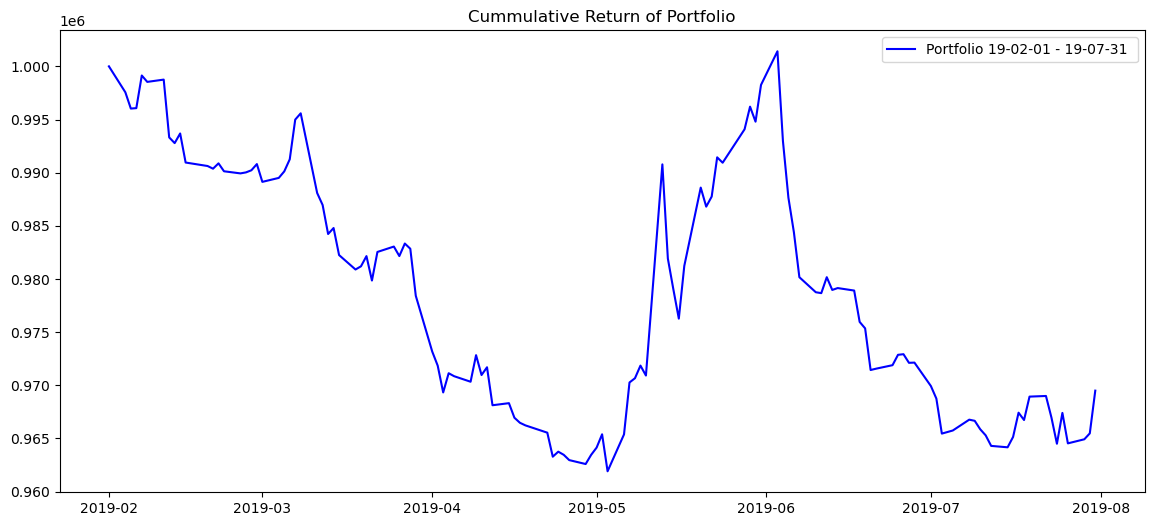

In [210]:
port = np.zeros((len(result_index), len(trial_df.columns)))

for idx, pair in enumerate(trial_df.columns):
    port[:, idx] = trial_df[pair][0]

plt.figure(figsize=(14,6))
plt.title('Cummulative Return of Portfolio')
plt.plot(result_index, np.average(port, axis=1), c='b',label=f'Portfolio {str(result_index[0])[2:11]}- {str(result_index[-1])[2:11]}')
plt.legend()
plt.show()

In [216]:
trial_df[trial_df.columns].iloc[1][0]

array([1000000.        ,  997048.05506134,  994915.20269012,
        995820.17740631,  995820.17740631,  995540.11679077,
        995548.54708099,  989337.14426422,  987954.23213196,
        987954.11212921,  987954.91212463,  987954.91212463,
        987276.39025879,  989138.74894714,  986401.00959015,
        985712.99836731,  985969.16078949,  986327.44387817,
        987786.46527863,  984621.64985657,  986038.00988007,
        986510.09670258,  989017.64956665,  993091.11723328,
        994339.03041077,  986889.63909912,  985376.03070068,
        982064.13996887,  982408.11752319,  979917.10734558,
        979917.10734558,  979917.10734558,  979917.10734558,
        974695.24617767,  982468.03759766,  983483.88303375,
        983483.88303375,  985332.95874023,  984219.47189331,
        981315.87876511,  975692.28444672,  975832.95083237,
        975832.95083237,  974681.73585129,  974681.73585129,
        973870.15961456,  975946.47685623,  975155.35931396,
        975205.53375244,

In [215]:
def get_mdd(x):
    """
    MDD(Maximum Draw-Down)
    :return: (peak_upper, peak_lower, mdd rate)
    """
    arr_v = np.array(x)
    peak_lower = np.argmax(np.maximum.accumulate(arr_v) - arr_v)
    peak_upper = np.argmax(arr_v[:peak_lower])
    return peak_upper, peak_lower, (arr_v[peak_lower] - arr_v[peak_upper]) / arr_v[peak_upper]

In [229]:
trial_df[trial_df.columns].iloc[1][0][:1]

array([1000000.])

In [244]:
mdd_tmp = [get_mdd(trial_df[trial_df.columns].iloc[1][0][:idx+2])[2] for idx in range(len(trial_df[trial_df.columns].iloc[1][0])-2)]
for x in range(2):
    mdd_tmp.insert(0, 0)
mdd_tmp

[0,
 0,
 -0.002951944938659668,
 -0.005084797309875488,
 -0.005084797309875488,
 -0.005084797309875488,
 -0.005084797309875488,
 -0.005084797309875488,
 -0.010662855735778808,
 -0.012045767868041991,
 -0.012045887870788575,
 -0.012045887870788575,
 -0.012045887870788575,
 -0.012723609741210937,
 -0.012723609741210937,
 -0.013598990409851075,
 -0.01428700163269043,
 -0.01428700163269043,
 -0.01428700163269043,
 -0.01428700163269043,
 -0.015378350143432617,
 -0.015378350143432617,
 -0.015378350143432617,
 -0.015378350143432617,
 -0.015378350143432617,
 -0.015378350143432617,
 -0.015378350143432617,
 -0.015378350143432617,
 -0.017935860031127928,
 -0.017935860031127928,
 -0.020082892654418944,
 -0.020082892654418944,
 -0.020082892654418944,
 -0.020082892654418944,
 -0.02530475382232666,
 -0.02530475382232666,
 -0.02530475382232666,
 -0.02530475382232666,
 -0.02530475382232666,
 -0.02530475382232666,
 -0.02530475382232666,
 -0.02530475382232666,
 -0.02530475382232666,
 -0.02530475382232666

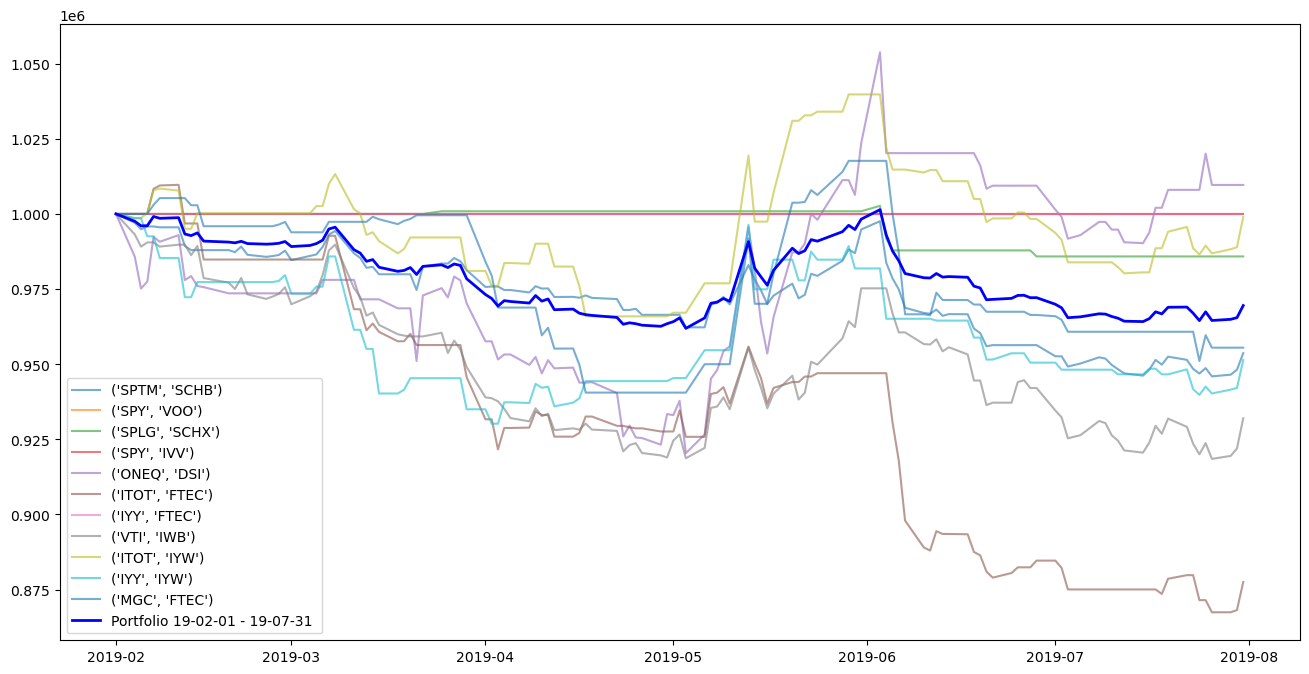

In [212]:
plt.figure(figsize=(16,8))

for x in list(trial_df.columns):
    plt.plot(result_index, trial_df[x][1].reshape(-1,1), alpha=0.6,label=f'{x}')
    
plt.plot(result_index, np.average(port, axis=1), linewidth=2, c='b',label=f'Portfolio {str(result_index[0])[2:11]}- {str(result_index[-1])[2:11]}')
plt.legend()
plt.show()

## 시그널

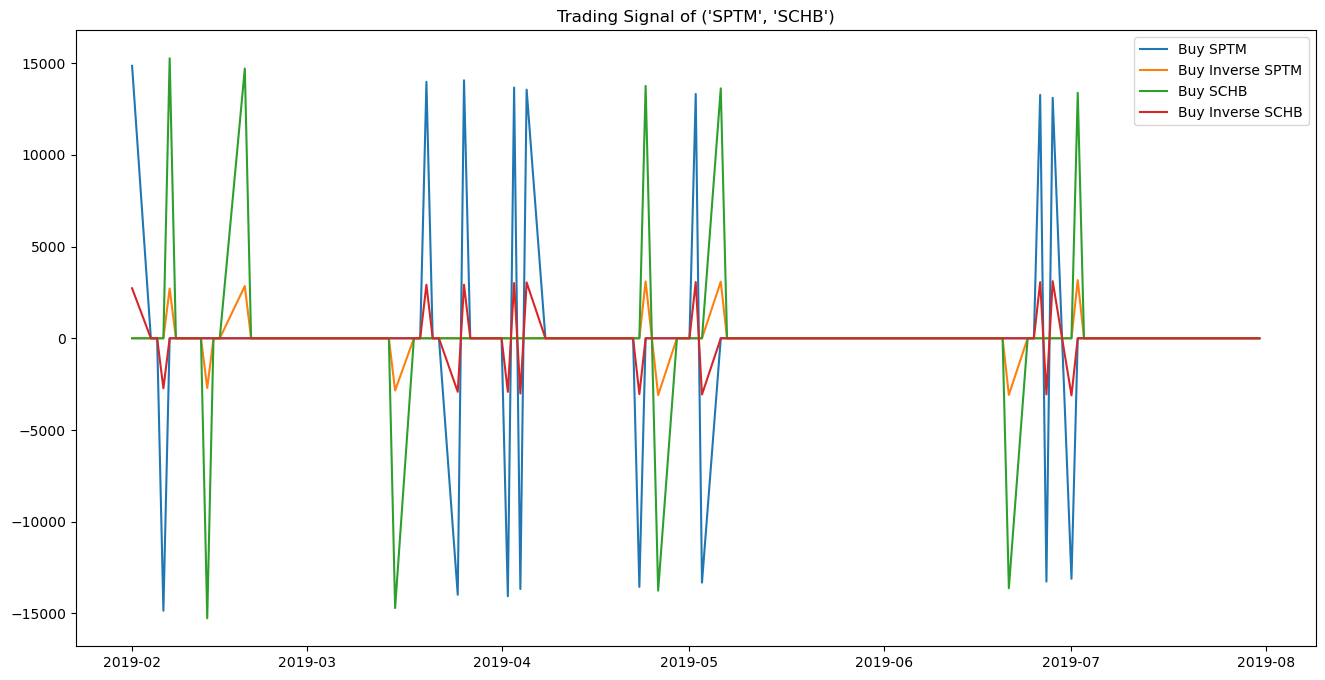

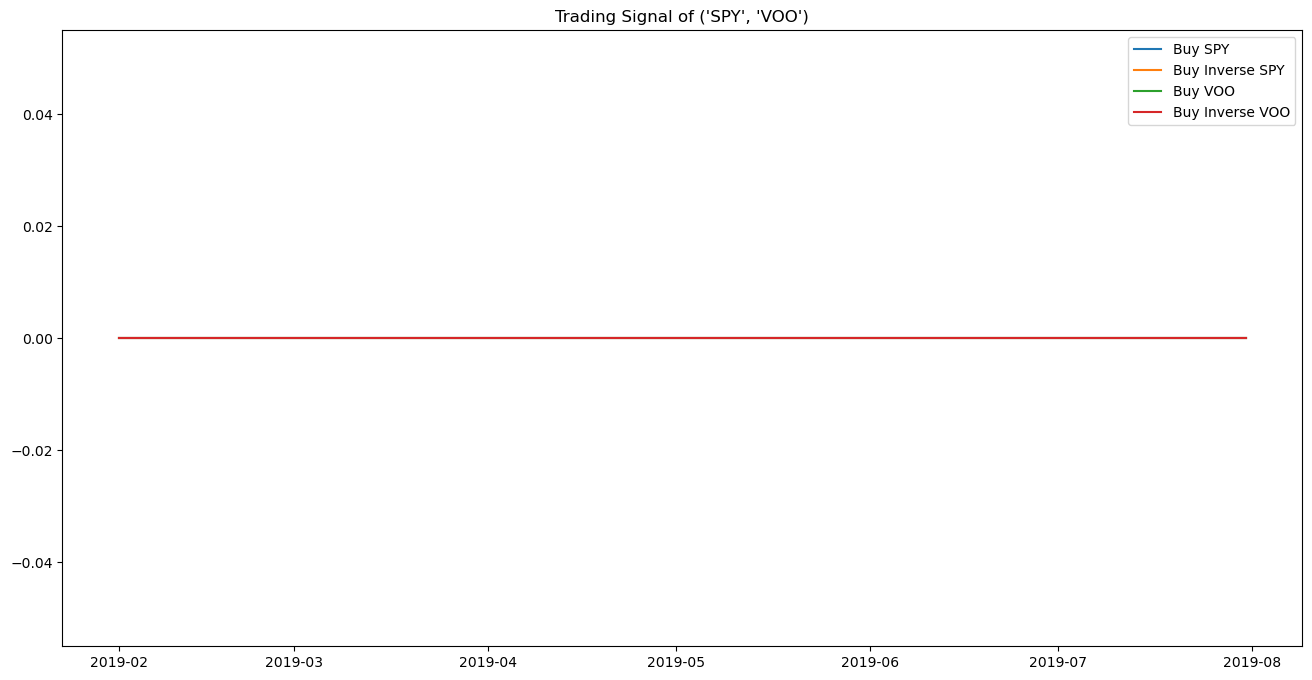

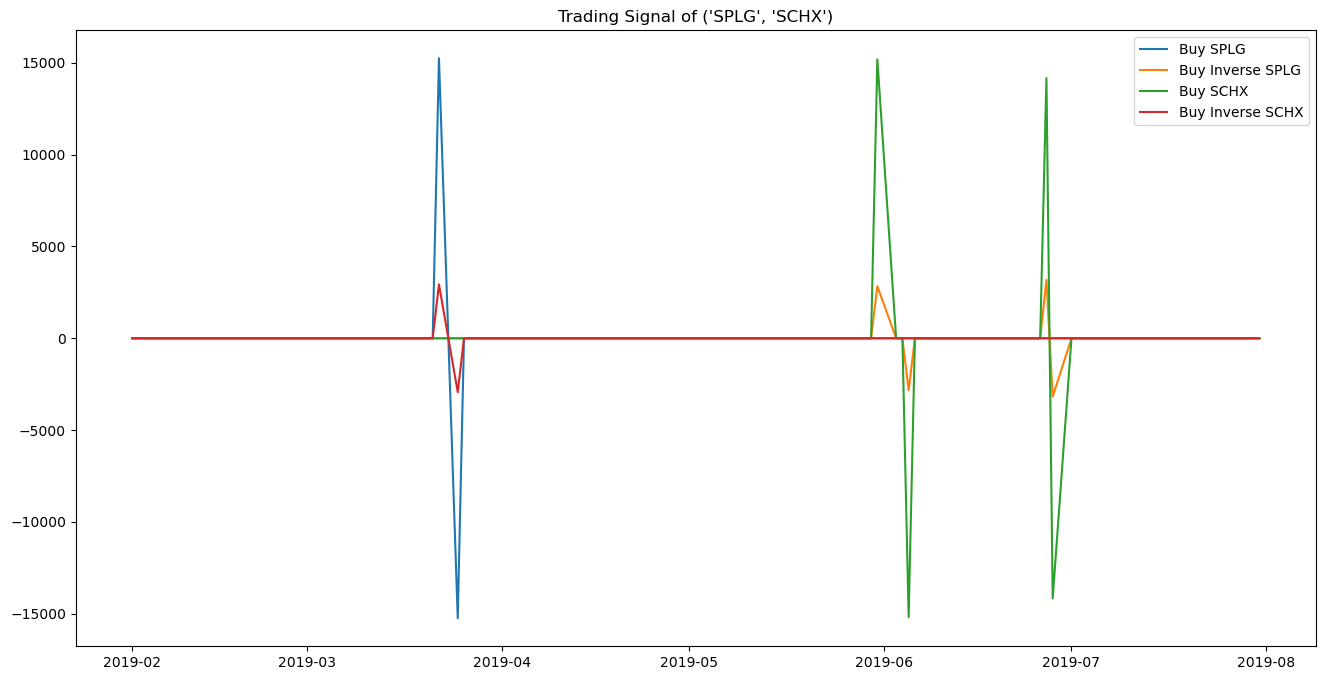

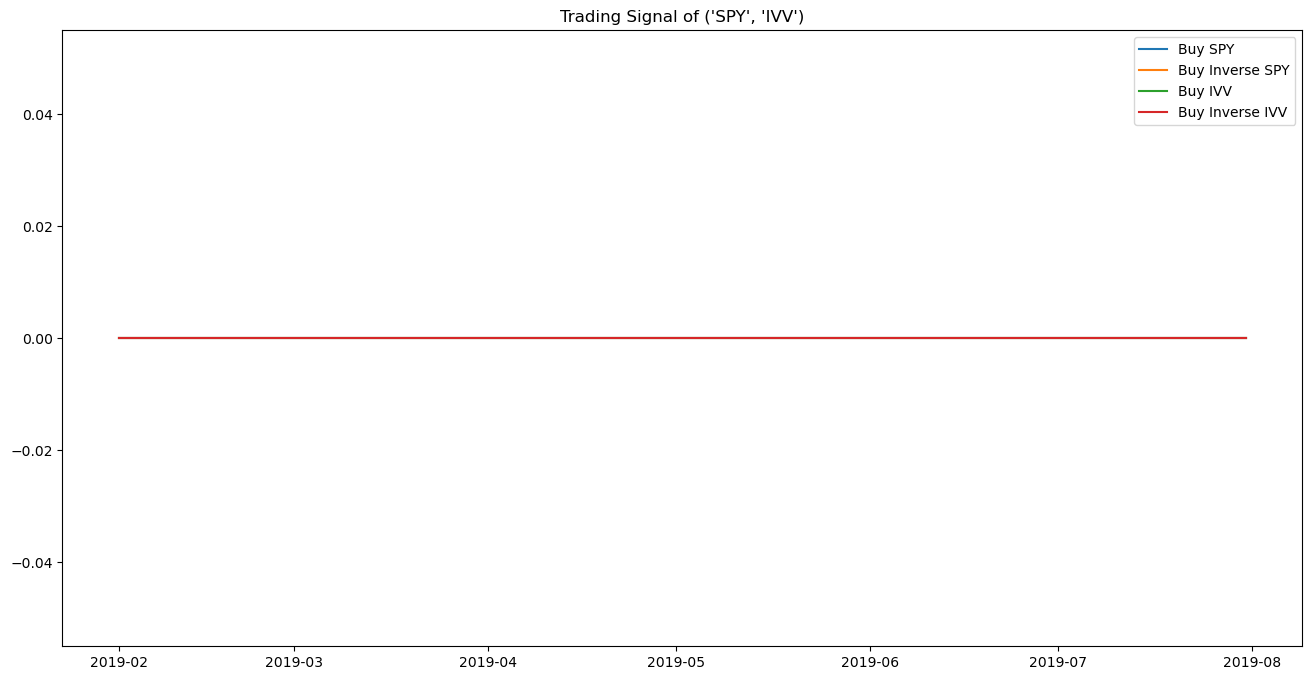

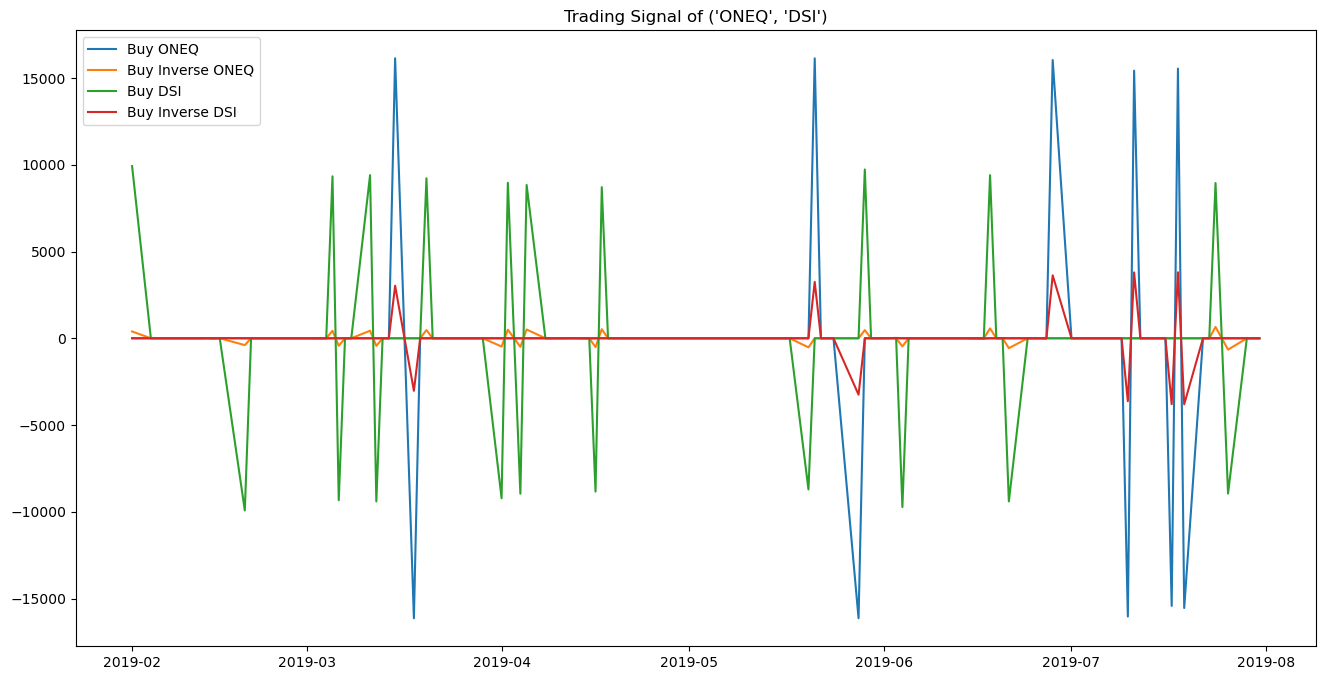

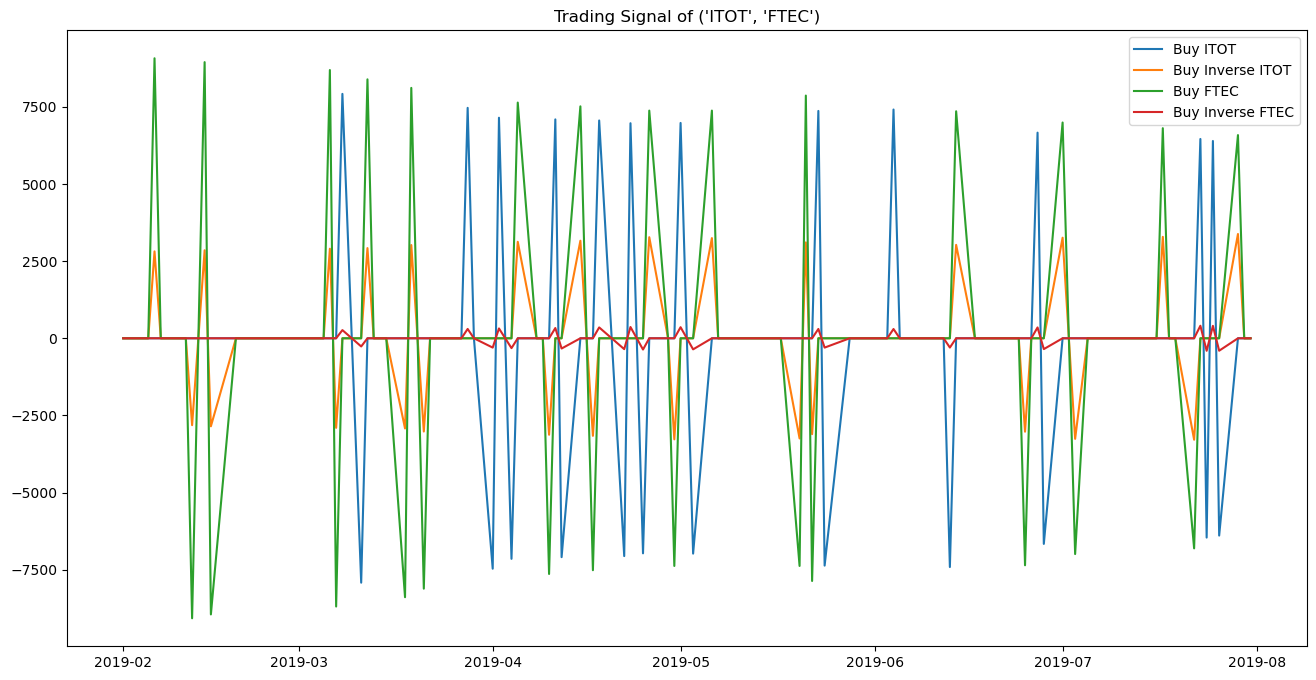

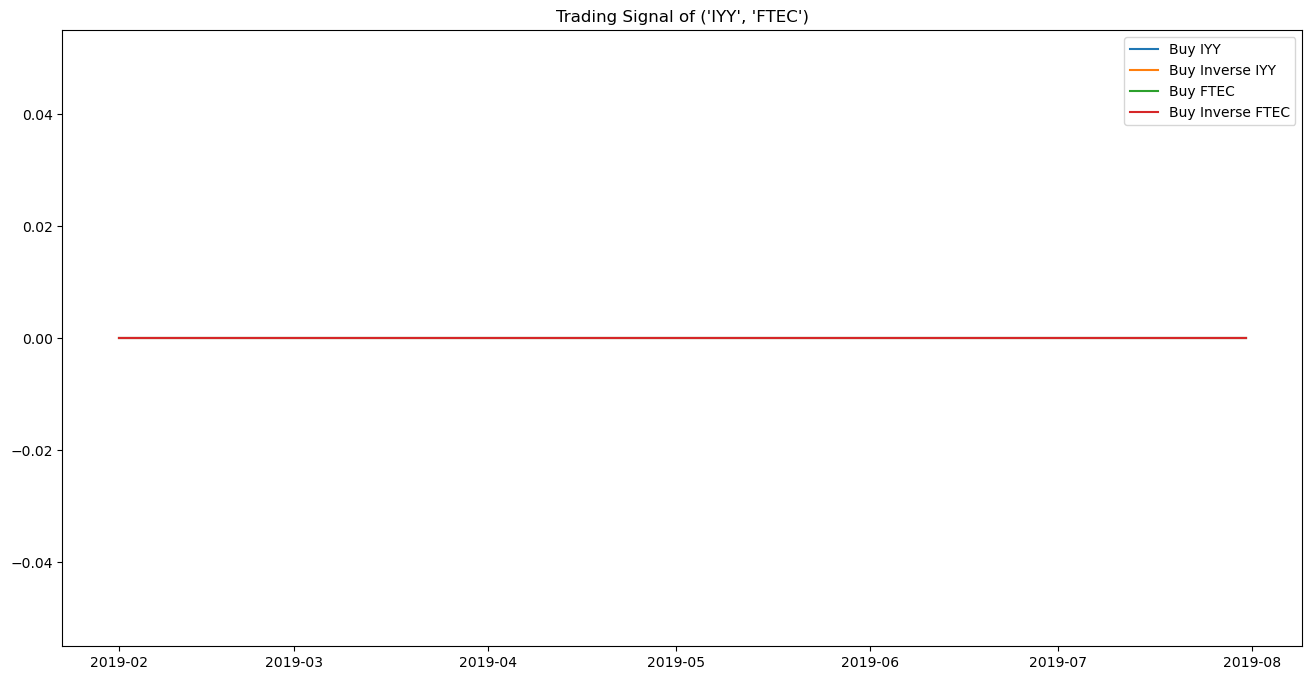

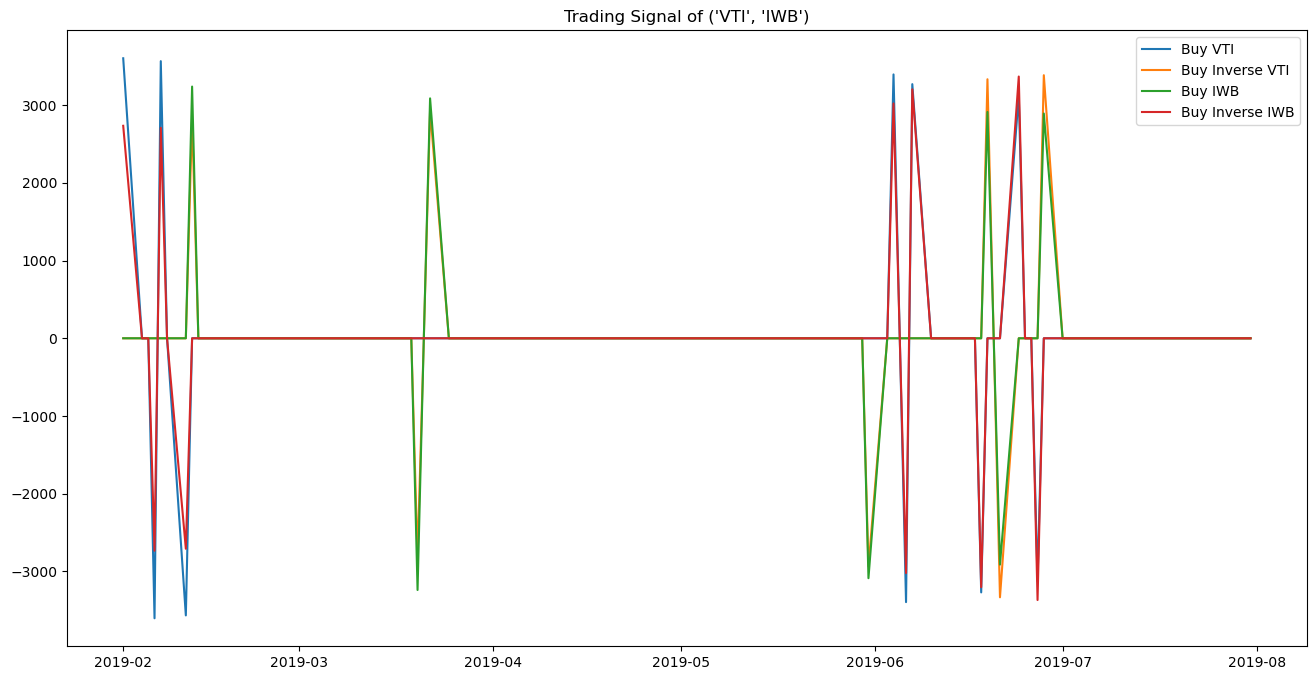

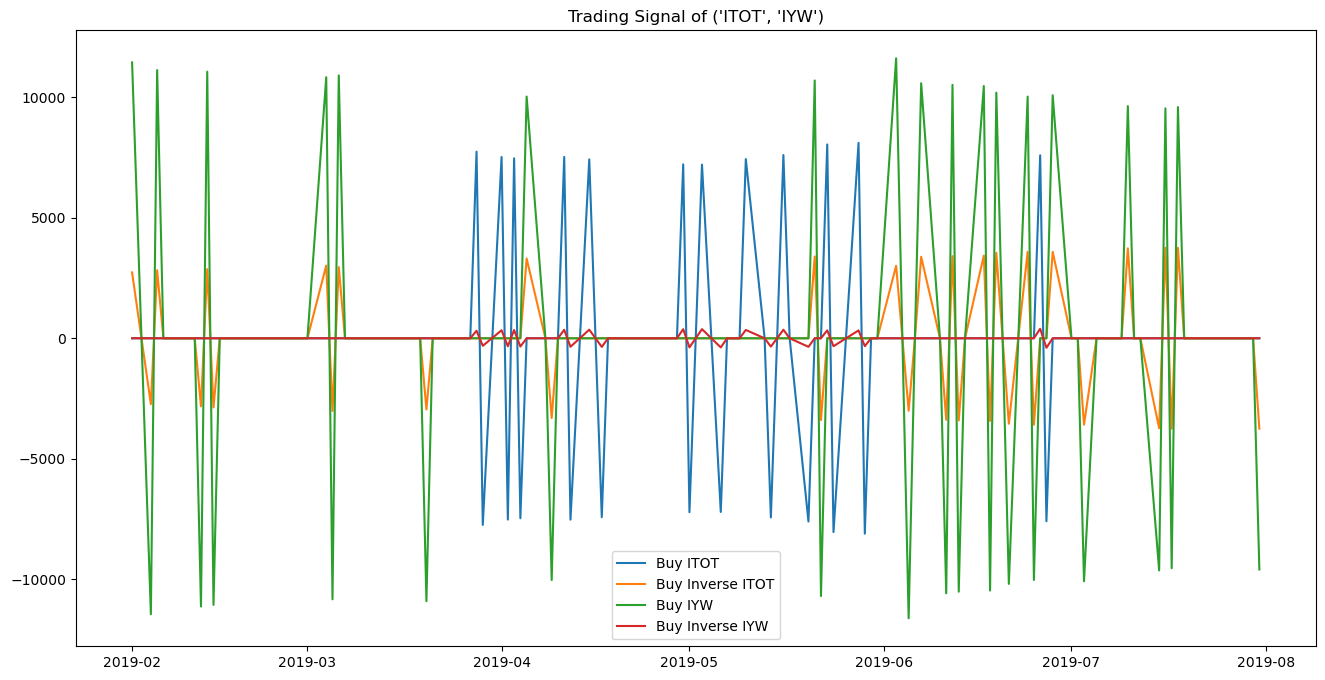

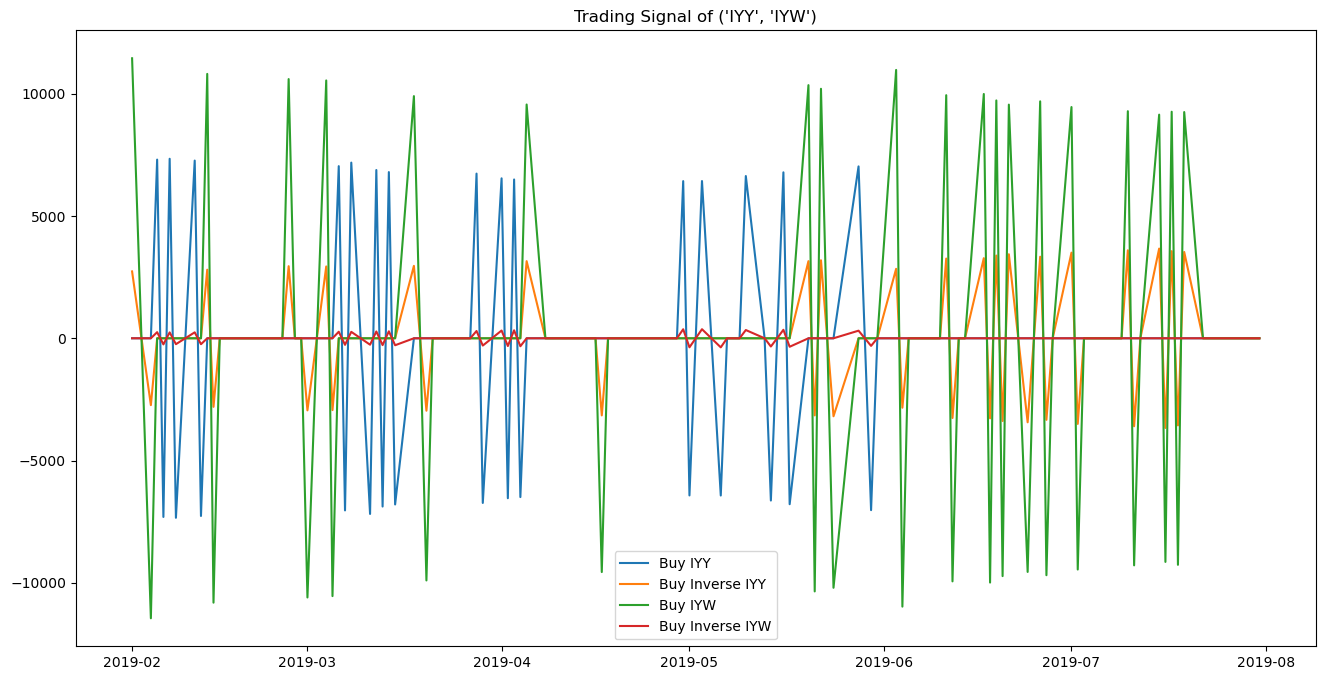

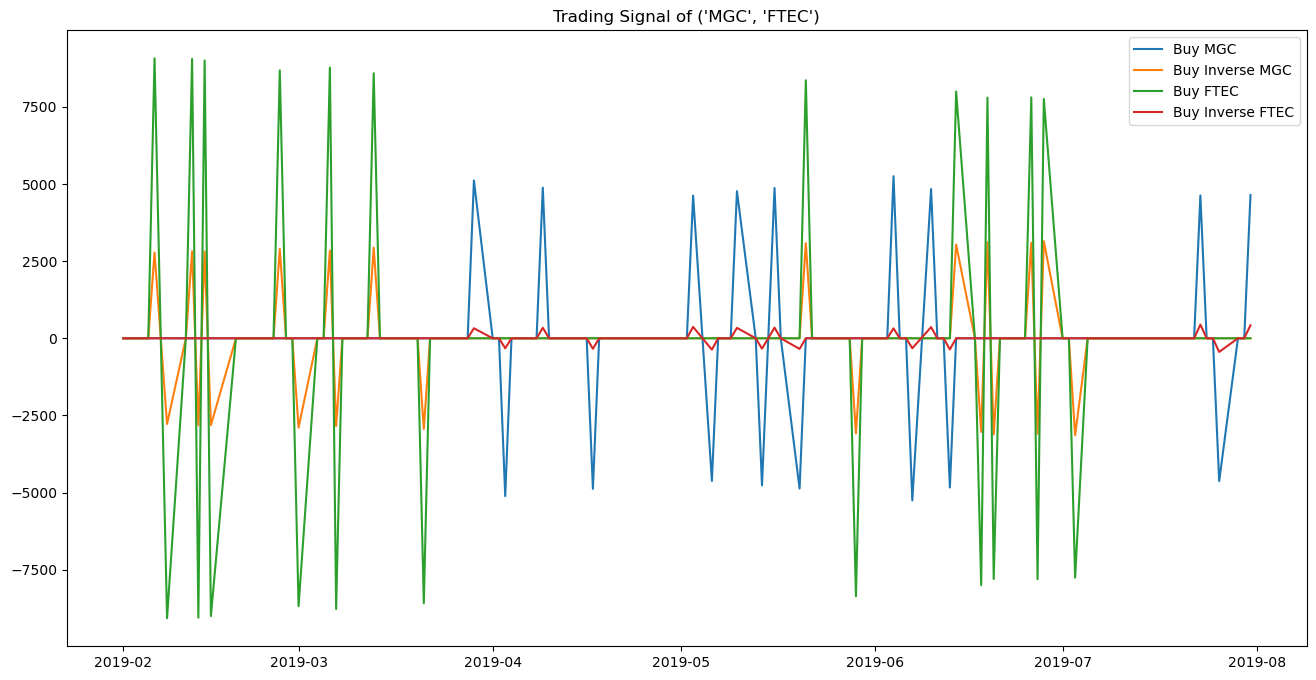

In [170]:
for name in trial_df.columns:
    signal = trial_df[name][3]
    plt.figure(figsize=(16,8))
    plt.title(f'Trading Signal of {name}')

    for x in range(len(signal)):
        tag = [f'Buy {name[0]}', f'Buy Inverse {name[0]}', f'Buy {name[1]}', f'Buy Inverse {name[1]}']
        plt.plot(result_index, signal[x], label=tag[x])
        
    plt.legend()
    plt.show()
    

In [ ]:
#(asset_per_pair_dic, total_asset_dic, threshold_dic, trading_vol_dic, transaction_cost_dic)

In [57]:
pair_name = []

list(result['trial_2'][0].keys())[0]

('SPTM', 'SCHB')

In [44]:
for x in range(len(result['trial_2'])):
    print(result['trial_2'][x])

KeyError: 0

In [83]:
trial_df[trial_columns[0]][0].shape

(1, 125)